<a href="https://colab.research.google.com/github/thedatadj/natural-language-processing/blob/main/english_spanish_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install "tensorflow-text>=2.11"
!pip install einops

In [2]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [3]:
#@title
class ShapeChecker():
    def __init__(self):
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        parsed = einops.parse_shape(tensor, names)

        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")

# The data

In [4]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file('spa-eng.zip',
                                      origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
                                      extract=True)
path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

2638744/2638744 [==============================] - 0s 0us/step


In [5]:
def load_data(path):
    text = path.read_text(encoding='utf-8')
    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]
    context = np.array([context for target, context in pairs])
    target = np.array([target for target, context in pairs])
    return target, context

In [6]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [7]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [9]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = tf.data.Dataset.from_tensor_slices((context_raw[is_train], target_raw[is_train]))
train_raw = train_raw.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_raw = tf.data.Dataset.from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
val_raw = val_raw.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break

tf.Tensor(
[b'Le dio una caja.' b'Yo era demasiado r\xc3\xa1pido.'
 b'\xc2\xbfEl coche parec\xc3\xada viejo?'
 b'Quiero terminar este trabajo a las cinco.'
 b'Dejamos la puerta abierta.'], shape=(5,), dtype=string)

tf.Tensor(
[b'He gave her a box.' b'I was too fast.' b'Did the car look old?'
 b'I want to finish this work by five.' b'We left the door open.'], shape=(5,), dtype=string)


## Text preprocessing

### Standardization

In [11]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [12]:
def tf_lower_and_split_punct(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [13]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


### Text Vectorization

In [14]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True
)

In [15]:
context_text_processor.adapt(train_raw.map(lambda context, target:context))

context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [16]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True
)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [17]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 29, 218, 23, 432, 4, 3], [2, 39, 71, 122, 271, 4, 3],
 [2, 13, 7, 158, 523, 426, 12, 3]]>

In [19]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] le dio una caja . [END]'

Text(0.5, 1.0, 'Mask')

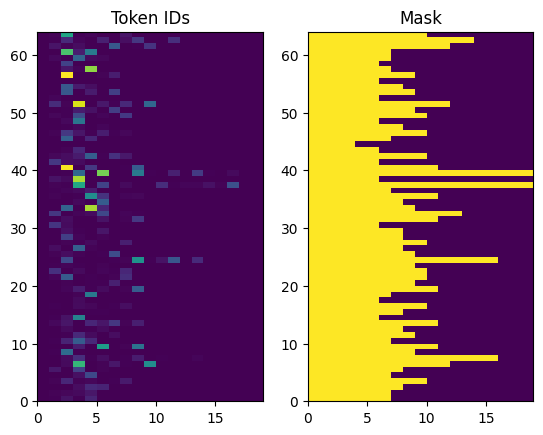

In [23]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

## Process the dataset

In [25]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:, :-1].to_tensor()
    targ_out = target[:, 1:].to_tensor()
    return (context, targ_in), targ_out

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [34]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy())
    print()
    print(ex_tar_in[0, :10].numpy())
    print(ex_tar_out[0, :10].numpy())

[   2   49 4026   21   43    4    3    0    0    0]

[  2   6  37   7 483   8  25  16   4   0]
[  6  37   7 483   8  25  16   4   3   0]


# The encoder/decoder

In [27]:
UNITS = 256

## The encoder

In [30]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                                   mask_zero=True)

        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                                      return_sequences=True,
                                      recurrent_initializer='glorot_uniform')
        )

    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')

        x = self.embedding(x)
        shape_checker(x, 'batch s units')

        x = self.rnn(x)
        shape_checker(x, 'batch s units')

        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

In [36]:
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 26)
Encoder output, shape (batch, s, units): (64, 26, 256)


## The attention layer

In [41]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        shape_checker = ShapeChecker()

        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True
        )

        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')

        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [42]:
attention_layer = CrossAttention(UNITS)

embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)

ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 26, 256)
Target sequence, shape (batch, t, units): (64, 23, 256)
Attention result, shape (batch, t, units): (64, 23, 256)
Attention weights, shape (batch, t, s):    (64, 23, 26)


In [43]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 0.9999999 , 0.9999999 , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ], dtype=float32)

Text(0.5, 1.0, 'Mask')

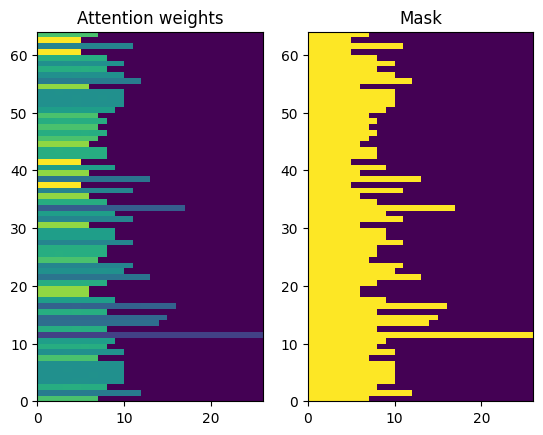

In [44]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask')

## The decoder

In [48]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]'
        )
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True
        )
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units

        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                   units, mask_zero=True)

        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        self.attention = CrossAttention(units)

        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

### Training

In [49]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch t')
    shape_checker(context, 'batch s units')

    x = self.embedding(x)
    shape_checker(x, 'batch t units')

    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')

    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')

    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
        return logits, state
    else:
        return logits

In [50]:
decoder = Decoder(target_text_processor, UNITS)

In [51]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 26, 256)
input target tokens shape: (batch, t) (64, 23)
logits shape shape: (batch, target_vocabulary_size) (64, 23, 5000)


### Inference

In [52]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [55]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [65]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
        context, next_token,
        state = state,
        return_state=True
    )

    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    done = done | (next_token == self.end_token)
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [66]:
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
    next_token, done, state = decoder.get_next_token(
        ex_context, next_token, done, state, temperature=1.0
    )
    tokens.append(next_token)

tokens = tf.concat(tokens, axis=-1)

result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'pay recent damaged unfinished photograph wolves hard bulgarian including brothers',
       b'desire excited acquainted abandoned criticize joke above zero mistakes prediction',
       b'taller beaten allowed records face treat growth talented circumstances winked'],
      dtype=object)

# The model

In [67]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units,
                 context_text_processor,
                 target_text_processor):
        super().__init__()
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)

        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        try:
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [69]:
model = Translator(UNITS, context_text_processor, target_text_processor)
logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 26)
Target tokens, shape: (batch, t) (64, 23)
logits, shape: (batch, t, target_vocabulary_size) (64, 23, 5000)


## Train

In [70]:
def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )
    loss = loss_fn(y_true, y_pred)

    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [71]:
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [72]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [73]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [74]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 33s 515ms/step - loss: 8.5184 - masked_acc: 9.3633e-05 - masked_loss: 8.5184


{'loss': 8.518407821655273,
 'masked_acc': 9.36329597607255e-05,
 'masked_loss': 8.518407821655273}

In [76]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/100
100/100 [==============================] - 131s 1s/step - loss: 5.0245 - masked_acc: 0.2634 - masked_loss: 5.0245 - val_loss: 4.0909 - val_masked_acc: 0.3554 - val_masked_loss: 4.0909
Epoch 2/100
100/100 [==============================] - 79s 789ms/step - loss: 3.6906 - masked_acc: 0.4043 - masked_loss: 3.6906 - val_loss: 3.3246 - val_masked_acc: 0.4518 - val_masked_loss: 3.3246
Epoch 3/100
100/100 [==============================] - 79s 788ms/step - loss: 3.1284 - masked_acc: 0.4794 - masked_loss: 3.1284 - val_loss: 2.8565 - val_masked_acc: 0.5164 - val_masked_loss: 2.8565
Epoch 4/100
100/100 [==============================] - 77s 769ms/step - loss: 2.7041 - masked_acc: 0.5378 - masked_loss: 2.7041 - val_loss: 2.5371 - val_masked_acc: 0.5569 - val_masked_loss: 2.5371
Epoch 5/100
100/100 [==============================] - 76s 766ms/step - loss: 2.3587 - masked_acc: 0.5905 - masked_loss: 2.3587 - val_loss: 2.2672 - val_masked_acc: 0.5976 - val_masked_loss: 2.2672
Epoch 6/100


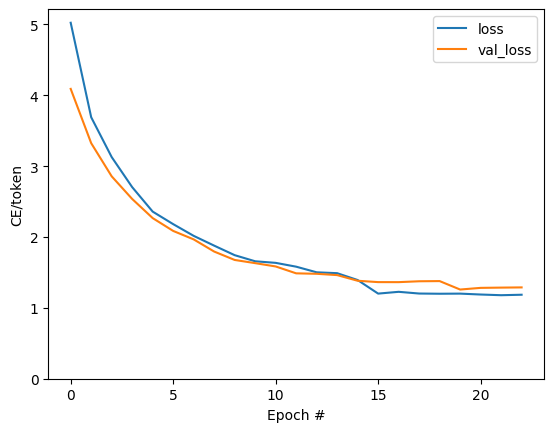

In [77]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

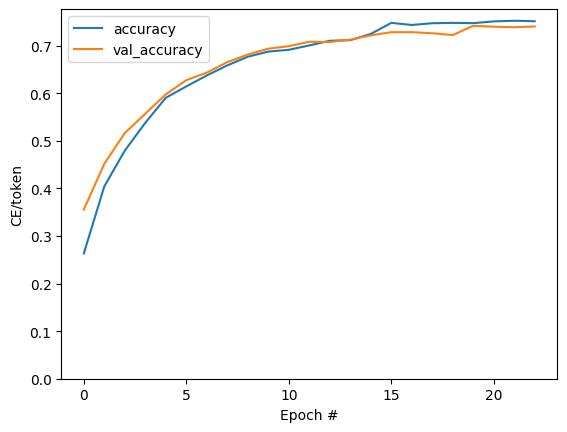

In [78]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Translate

In [79]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [90]:
result = model.translate(['¿Donde esta la biblioteca?'])
result[0].numpy().decode()

'where is the library ? '